In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten,Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_dir='/kaggle/input/private-datasetrar/227x227/train'
valid_dir='/kaggle/input/private-datasetrar/227x227/valid'
test_dir='/kaggle/input/private-datasetrar/227x227/test'

In [3]:
batch_size = 32
img_height,img_width = (227,227)
num_classes = 2
EPOCHS = 50

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1593 images belonging to 2 classes.


In [6]:
valid_generator = train_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

Found 457 images belonging to 2 classes.


In [7]:
test_generator = train_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

Found 455 images belonging to 2 classes.


In [8]:
x, y = test_generator.next()
x.shape  # Display to confirm the shape of the input

(1, 227, 227, 3)

In [9]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Diseased', 'Healthy']


In [10]:
target_names = ['Diseased', 'Healthy']

In [11]:
def AlexNet():
    input_layer = Input(shape=train_generator.image_shape)

    # First convolutional layer
    X = Conv2D(filters=96, kernel_size=(11, 11), strides=4, activation='relu', padding="same")(input_layer)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # Second convolutional layer
    X = Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding="same")(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # Third convolutional layer
    X = Conv2D(filters=384, kernel_size=(3, 3), strides=1, activation='relu', padding="same")(X)
    X = BatchNormalization()(X)

    # Fourth convolutional layer
    X = Conv2D(filters=384, kernel_size=(3, 3), strides=1, activation='relu', padding="same")(X)
    X = BatchNormalization()(X)

    # Fifth convolutional layer
    X = Conv2D(filters=256, kernel_size=(3, 3), strides=1, activation='relu', padding="same")(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # Flattening
    X = Flatten()(X)

    # First fully connected layer
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.5)(X)

    # Second fully connected layer
    X = Dense(4096, activation='relu')(X)
    X = Dropout(0.5)(X)

    # Output layer
    predictions = Dense(train_generator.num_classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs=input_layer, outputs=predictions, name="AlexNet")
    return model

In [12]:
model = AlexNet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 57, 57, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 57, 57, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 256)      1024

In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Custom callback to save the model at specific epochs
class SaveModelAtEpochs(Callback):
    def __init__(self, checkpoint_filepath, save_epochs):
        super(SaveModelAtEpochs, self).__init__()
        self.checkpoint_filepath = checkpoint_filepath
        self.save_epochs = save_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.save_epochs:
            self.model.save(self.checkpoint_filepath.format(epoch=epoch+1))

# Define the checkpoint filepath for the best model
checkpoint_filepath_best = '/kaggle/working/Alexnet/50epoch.{epoch:02d}-{val_loss:.2f}.h5'

# Create the ModelCheckpoint callback for the best model
checkpoint_best = ModelCheckpoint(
    filepath=checkpoint_filepath_best,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Define the checkpoint filepath and save epochs for the custom callback
checkpoint_filepath_epochs = '/kaggle/working/Alexnet/save_by_epochs/alex_model_{epoch}.h5'
save_epochs = [10, 20, 30, 40, 50]

# Create the custom callback to save the model at specific epochs
custom_checkpoint = SaveModelAtEpochs(checkpoint_filepath_epochs, save_epochs)



In [14]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[checkpoint_best, custom_checkpoint]
)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 11.3173 - accuracy: 0.5104
Epoch 1: val_accuracy improved from -inf to 0.49672, saving model to /kaggle/working/Alexnet/50epoch.01-24.83.h5
50/50 [==============================] - 42s 608ms/step - loss: 11.3173 - accuracy: 0.5104 - val_loss: 24.8291 - val_accuracy: 0.4967
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 1.0002 - accuracy: 0.5612
Epoch 2: val_accuracy improved from 0.49672 to 0.51641, saving model to /kaggle/working/Alexnet/50epoch.02-1.41.h5
50/50 [==============================] - 27s 536ms/step - loss: 1.0002 - accuracy: 0.5612 - val_loss: 1.4129 - val_accuracy: 0.5164
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.7993 - accuracy: 0.5763
Epoch 3: val_accuracy did not improve from 0.51641
50/50 [==============================] - 25s 504ms/step - loss: 0.7993 - accuracy: 0.5763 - val_loss: 1.4338 - val_accuracy: 0.5142
Epoch 4/50
50/50 [======================

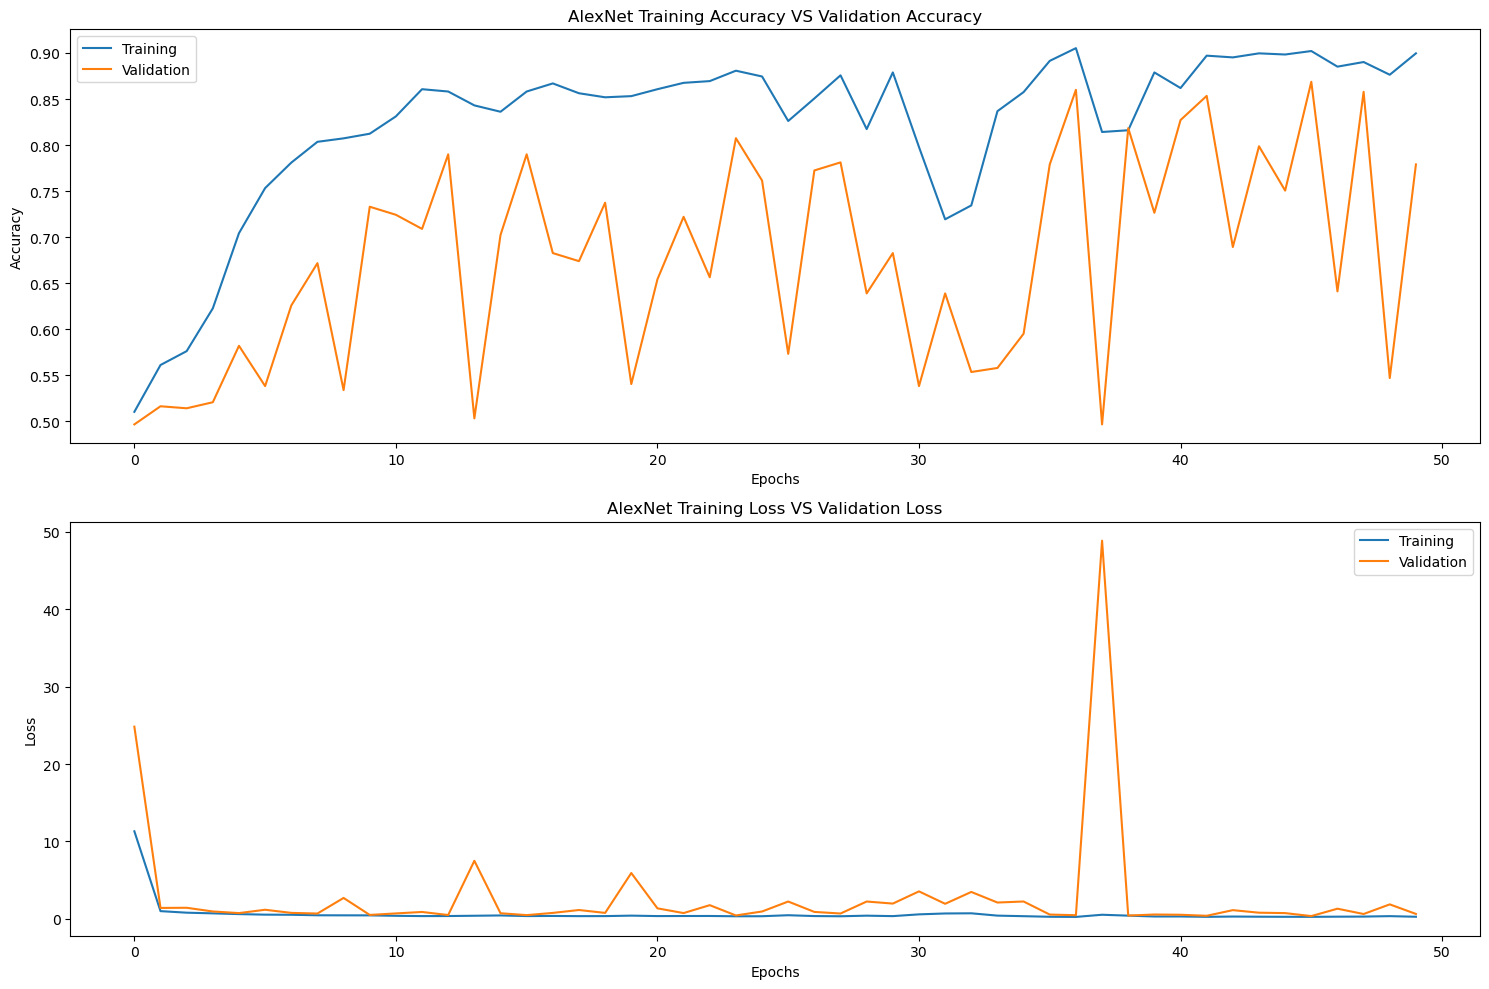

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot Training Accuracy and Validation Accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('AlexNet Training Accuracy VS Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Training', 'Validation'])

# Plot Training Loss and Validation Loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('AlexNet Training Loss VS Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['Training', 'Validation'])

plt.tight_layout()
plt.show()


In [16]:
import glob
# Loading the best model
saved_models_dir = '/kaggle/working/Alexnet/'
saved_model_files = glob.glob(os.path.join(saved_models_dir, '*.h5'))
saved_model_files.sort()
best_model_file = saved_model_files[-1]
best_model = tf.keras.models.load_model(best_model_file)

# Saving the best model with a different name
best_model.save('/kaggle/working/Alexnet/Saved_Model/Best_AlexNet.h5')

In [17]:
# Evaluating the best model on the validation set
test_loss, test_acc = best_model.evaluate(valid_generator, verbose = 2)
print('\nVal_accuracy: ', test_acc)
print('\nVal_loss: ', test_loss)

457/457 - 6s - loss: 0.3279 - accuracy: 0.8600 - 6s/epoch - 14ms/step

Val_accuracy:  0.8599562644958496

Val_loss:  0.3279467225074768


for best Alex model
1/1 [==============================] - 0s 18ms/step
test accuracy :87.47252747252747


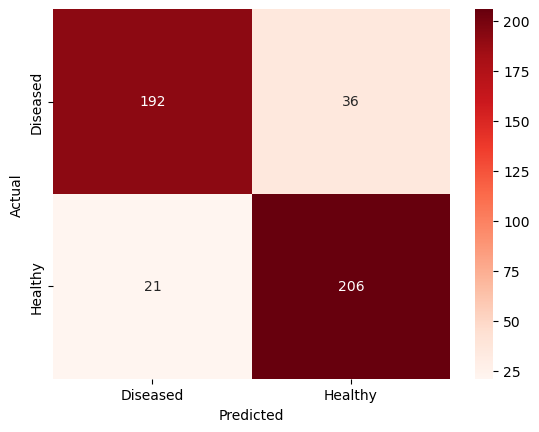

              precision    recall  f1-score   support

    Diseased       0.90      0.84      0.87       228
     Healthy       0.85      0.91      0.88       227

    accuracy                           0.87       455
   macro avg       0.88      0.87      0.87       455
weighted avg       0.88      0.87      0.87       455



In [18]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("for best Alex model")
model = tf.keras.models.load_model('/kaggle/working/Alexnet/Saved_Model/Best_AlexNet.h5')

filenames = test_generator.filenames
nb_samples = len(test_generator)

y_prob = []
y_act = []

test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
print('test accuracy :{}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))
# Generate classification report
plt.show()
classification_rep = classification_report(out_df['actual_class'], out_df['predicted_class'], target_names=target_names)

print(classification_rep)

Epoch 1
1/1 [==============================] - 0s 18ms/step


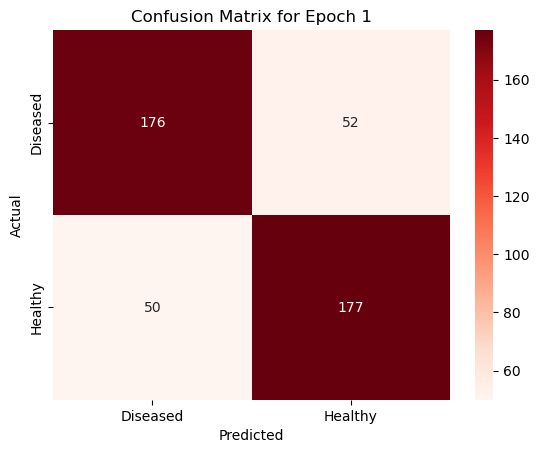

Test accuracy: 77.58241758241759
              precision    recall  f1-score   support

    Diseased       0.78      0.77      0.78       228
     Healthy       0.77      0.78      0.78       227

    accuracy                           0.78       455
   macro avg       0.78      0.78      0.78       455
weighted avg       0.78      0.78      0.78       455

-----------------------------------------------------
Epoch 2
1/1 [==============================] - 0s 17ms/step


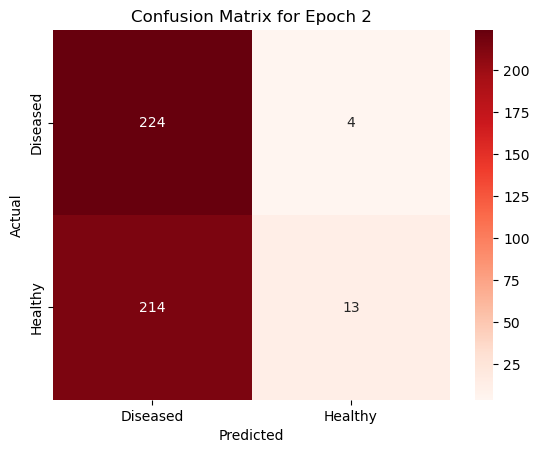

Test accuracy: 52.087912087912095
              precision    recall  f1-score   support

    Diseased       0.51      0.98      0.67       228
     Healthy       0.76      0.06      0.11       227

    accuracy                           0.52       455
   macro avg       0.64      0.52      0.39       455
weighted avg       0.64      0.52      0.39       455

-----------------------------------------------------
Epoch 3
1/1 [==============================] - 0s 18ms/step


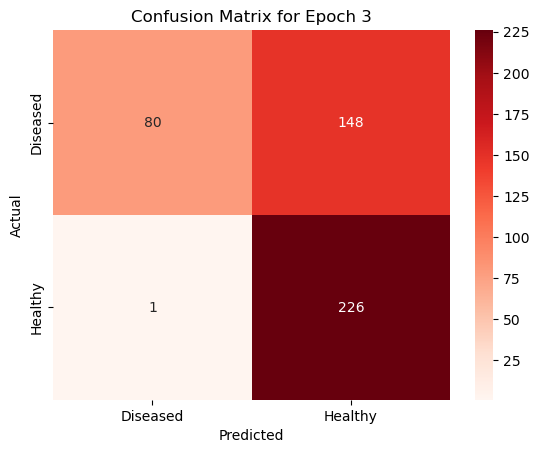

Test accuracy: 67.25274725274726
              precision    recall  f1-score   support

    Diseased       0.99      0.35      0.52       228
     Healthy       0.60      1.00      0.75       227

    accuracy                           0.67       455
   macro avg       0.80      0.67      0.63       455
weighted avg       0.80      0.67      0.63       455

-----------------------------------------------------
Epoch 4
1/1 [==============================] - 0s 19ms/step


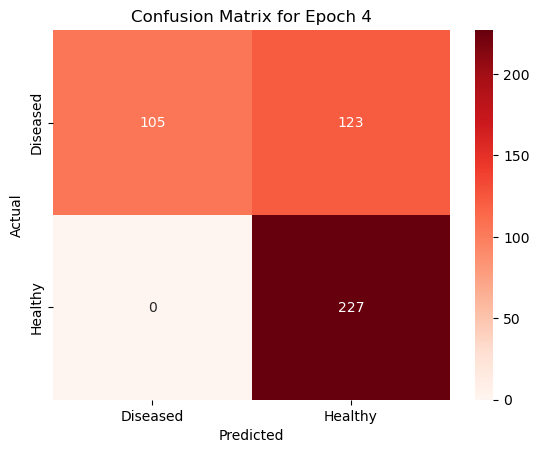

Test accuracy: 72.96703296703296
              precision    recall  f1-score   support

    Diseased       1.00      0.46      0.63       228
     Healthy       0.65      1.00      0.79       227

    accuracy                           0.73       455
   macro avg       0.82      0.73      0.71       455
weighted avg       0.82      0.73      0.71       455

-----------------------------------------------------
Epoch 5
1/1 [==============================] - 0s 23ms/step


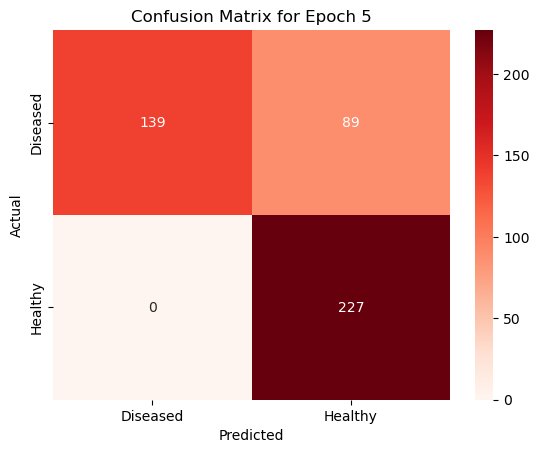

Test accuracy: 80.43956043956044
              precision    recall  f1-score   support

    Diseased       1.00      0.61      0.76       228
     Healthy       0.72      1.00      0.84       227

    accuracy                           0.80       455
   macro avg       0.86      0.80      0.80       455
weighted avg       0.86      0.80      0.80       455

-----------------------------------------------------


In [19]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

saved_model_filepaths = [
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_10.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_20.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_30.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_40.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_50.h5'
]

# Iterate over the saved model file paths
for epoch, model_filepath in enumerate(saved_model_filepaths, start=1):
    print("Epoch {}".format(epoch))
    
    # Load the model
    model = tf.keras.models.load_model(model_filepath)

    filenames = test_generator.filenames
    nb_samples = len(test_generator)

    y_prob = []
    y_act = []

    test_generator.reset()
    for _ in range(nb_samples):
        X_test, Y_test = test_generator.next()
        y_prob.append(model.predict(X_test))
        y_act.append(Y_test)

    predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
    actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

    out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

    confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
    plt.title('Confusion Matrix for Epoch {}'.format(epoch))
    plt.show()

    print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))

    # Generate classification report
    classification_rep = classification_report(out_df['actual_class'], out_df['predicted_class'], target_names=target_names)
    print(classification_rep)
    print("-----------------------------------------------------")


import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# List of saved model filepaths
saved_model_filepaths = [
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_10.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_20.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_30.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_40.h5',
    '/kaggle/working/Alexnet/save_by_epochs/alex_model_50.h5'
]

target_names = ['Diseased', 'Healthy']

# Load each saved model and make predictions
classification_reports = []
for filepath in saved_model_filepaths:
    model = keras.models.load_model(filepath)

    y_prob = []
    y_act = []

    test_generator.reset()
    for _ in range(nb_samples):
        X_test, Y_test = test_generator.next()
        y_prob.append(model.predict(X_test))
        y_act.append(Y_test)

    predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
    actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

    out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

    classification_rep = classification_report(out_df['actual_class'], out_df['predicted_class'], target_names=target_names)
    classification_reports.append(classification_rep)

# Print the classification reports for each epoch
for epoch, classification_rep in enumerate(classification_reports, start=1):
    print(f"Classification Report for Epoch {epoch}:")
    print(classification_rep)
    print()